In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [37]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
import xgboost as xgb
from sklearn.model_selection import train_test_split

print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [38]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

In [39]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

print('Reading train data...')
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
train = read_file(path = TRAIN_PATH)


Reading train data...
shape of data: (5531451, 190)


In [40]:
train['customer_ID'].nunique()

458913

In [41]:

# fig, ax = plt.subplots(figsize=(20,5))
# train.groupby("S_2")['customer_ID'].count().plot()
# plt.title("train profiles vs timeline")
# plt.show()

# fig, ax = plt.subplots(figsize=(20,5))
# test_df.groupby("S_2")['customer_ID'].count().plot()
# plt.title("test profiles vs timeline")
# plt.show()

In [42]:
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
train_labels.shape

(458913, 2)

In [43]:
train_labels['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int64

In [44]:
train_labels['customer_ID'].nunique()

458913

**Aggregating Data at Customer Level**

In [46]:
def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'sum', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train_agg = process_and_feature_engineer(train)


shape after engineering (458913, 564)


**Importing Train Lables  and converting hex_int**

In [47]:
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train_agg = train_agg.merge(targets, left_index=True, right_index=True, how='left')
train_agg.target = train_agg.target.astype('int8')
train_agg

,P_2_mean,P_2_sum,P_2_last,D_39_mean,D_39_sum,D_39_last,B_1_mean,B_1_sum,B_1_last,B_2_mean,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
-8555975599531278889,0.793137,10.310781,0.745855,0.000000,0,0,0.005538,0.071995,0.009473,0.815943,...,13,2,1,13,-1,1,13,6,1,0
-8555958178988682704,0.702967,9.138567,0.715618,0.846154,11,0,0.018893,0.245614,0.029965,0.807204,...,13,2,1,13,-1,1,13,3,3,0
-8555908418013587357,0.452330,5.880292,0.433673,8.538462,111,2,0.540105,7.021360,0.491156,0.051237,...,13,0,2,13,-1,1,13,6,2,1
-8555857140704058447,0.799070,10.387907,0.825682,7.230769,94,3,0.061620,0.801062,0.096229,0.219457,...,13,0,2,13,1,1,13,3,3,0
-8555759474221738839,-9.620776,-125.070084,0.032572,2.000000,26,0,0.239013,3.107170,0.223984,0.149827,...,13,2,2,13,-1,1,13,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185832047584928773,0.799579,10.394530,0.728077,0.000000,0,0,0.004310,0.056035,0.000526,0.814852,...,13,0,1,13,-1,1,13,6,1,0
9185861269631023151,0.795245,10.338183,0.780886,5.384615,70,0,0.025507,0.331597,0.000184,0.846660,...,13,0,1,13,-1,1,13,6,1,0
9185887485761272302,0.644257,6.442567,0.655224,0.000000,0,0,0.018297,0.182965,0.006280,0.835542,...,10,0,2,10,-1,1,10,6,2,0


**Missing Values Check**

In [48]:
total = train_agg.isnull().sum().sort_values(ascending = False)
total=total.to_pandas().to_frame()
percent = (train_agg.isnull().sum()/train_agg.isnull().count()*100).sort_values(ascending = False)
percent=percent.to_pandas().to_frame()

pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,,P_2_mean,P_2_sum,P_2_last,D_39_mean,D_39_sum,D_39_last,B_1_mean,B_1_sum,B_1_last,B_2_mean,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
Total,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
var = train_agg.columns.values
sum_var = [c for c in var if c.endswith('_sum')]
# filter(lambda x:x.endswith('_sum'),var)


**WOE & IV Calculation**

In [49]:

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
#         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF


In [50]:
new_df,woe_df=iv_woe(train_agg.to_pandas(),'target',show_woe=False)

In [51]:
woe_df.head(10)
woe_df.to_csv("Woedf.csv")
new_df.head(10)
new_df.to_csv("newdf.csv")

In [55]:
sel_var1 = new_df.loc[ new_df.IV > 2,:]

var_names= list(sel_var1.Variable)
# var_names
var_names.insert(-1,'target')
sel_var1.shape

(9, 2)

In [56]:
sel_var1

,Variable,IV
0,P_2_mean,3.042347
0,P_2_sum,2.795609
0,P_2_last,3.549184
0,D_48_last,2.258412
0,B_7_last,2.090293
0,B_10_last,2.006790
0,B_18_sum,2.303151
0,B_18_last,2.094712
0,B_23_last,2.044671


**KS Test**

In [57]:
aa= []
    #Extract Column Names
train_agg1=train_agg.to_pandas()
cols = train_agg1.columns
for ivars in cols[~cols.isin([train_agg1.target])]:
#     print("The KS of " + ivars + " " + str(ks_2samp(train_agg1[ivars] ,train_agg1.target)) )

    aa.append("The KS of " + ivars + " " + str(ks_2samp(train_agg1[ivars] ,train_agg1.target)))
ks_df= pd.DataFrame(aa)
ks_df.to_csv("KS.csv")

**Base Model**

In [58]:
train_agg1=train_agg.to_pandas().loc[:,var_names]
X_train, X_test, y_train, y_test = train_test_split(train_agg1.drop(['target'],axis=1),train_agg1.target, test_size = 0.2, random_state = 0)
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
predictions = xgb_classifier.predict(X_test)
# print("Accuracy of Model::",accuracy_score(y_test,predictions))


In [59]:

print('AUC = %.2f' % roc_auc_score(y_test, predictions))  #1

AUC = 0.83


In [60]:
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

**Bayesian Hyperparameter Optimisation**

In [66]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
# Objective function
def objective(params):
    
    xgboost = xgb.XGBClassifier(seed=0, **params)
    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='recall', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 30, trials = bayes_trials)

100%|██████████| 30/30 [1:04:26<00:00, 128.87s/trial, best loss: -0.7655722711073265]


In [67]:
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

{'colsample_bytree': 5, 'gamma': 3, 'learning_rate': 1, 'max_depth': 0, 'reg_alpha': 3, 'reg_lambda': 0}
{'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.001, 'max_depth': 3, 'reg_alpha': 1, 'reg_lambda': 1e-05}


In [68]:
# Train model using the best parameters
xgboost_bo = xgb.XGBClassifier(seed=0, 
                           colsample_bytree=0.8, 
                           gamma=0.3, 
                           learning_rate=0.001, 
                           max_depth=3, 
                           reg_alpha=1,
                           reg_lambda=1e-05
                           ).fit(X_train,y_train)
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_test)
# Get predicted probabilities
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test)[:,1]
# Get performance metrics
precision, recall, fscore, support = score(y_test, bayesian_opt_predict)
# Print result
print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')
print('AUC = %.2f' % roc_auc_score(y_test, bayesian_opt_predict)) 

The recall value for the xgboost Bayesian optimization is 0.7629
AUC = 0.83


In [76]:
bayesian_opt_train_pro = xgboost_bo.predict_proba(X_train)[:,1]

Train Threshold value is: 0.47824147
Valid Threshold value is: 0.47773325


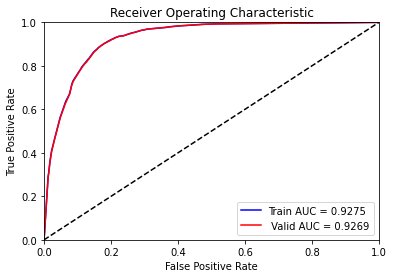

In [79]:
from sklearn import metrics
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, bayesian_opt_train_pro)
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
auc_score = metrics.auc(false_positive_rate, true_positive_rate)
print("Train Threshold value is:", optimal_threshold)

false_positive_rate1, true_positive_rate1, thresholds = metrics.roc_curve(y_test,bayesian_opt_predict_prob)
optimal_idx = np.argmax(true_positive_rate1 - false_positive_rate1)
optimal_threshold1 = thresholds[optimal_idx]
auc_score1 = metrics.auc(false_positive_rate1, true_positive_rate1)
print("Valid Threshold value is:", optimal_threshold1)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Train AUC = {0:.4f}'.format(auc_score))
plt.plot(false_positive_rate1, true_positive_rate1, 'r', label=' Valid AUC = {0:.4f}'.format(auc_score1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()